# Gray-Scott model
# 1. Initialization

In [14]:
# import packages
using Printf
using Glob
using Plots
import PyPlot
import PyCall

In [20]:
# constants and parameters 
const nx = 256
const dx = 0.01
const dt = 1
const difu = 2e-5
const difv = 1e-5

const cf, ck = 0.012, 0.05
params1 = Dict("f" => 0.012, "k" => 0.05); # wandering spots
params2 = Dict("f" => 0.025, "k" => 0.05); # waves

In [32]:
# define the initial condition

mx = div(nx,2)
sx = 20
sy = 10
u=ones(nx,nx)
u[(mx-4):(mx+5),(mx-9):(mx+10)]=ones(10,20)*0.5;
u+=reshape(rand(nx*nx)*0.1,nx,nx);
v=zeros(nx,nx)
v[(mx-4):(mx+5),(mx-9):(mx+10)]=ones(10,20)*0.25;
v+=reshape(rand(nx*nx)*0.1,nx,nx);
u0 = u;
v0 = v;

In [4]:
pyplot()

Plots.PyPlotBackend()

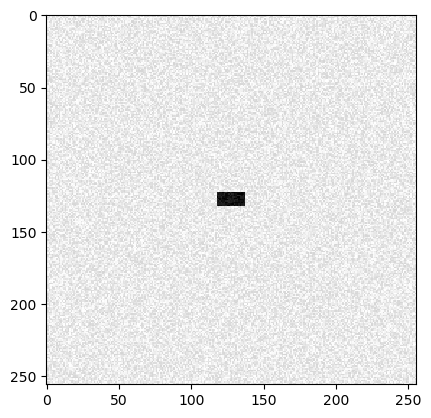

PyObject <matplotlib.image.AxesImage object at 0x13df1c898>

In [17]:
PyPlot.imshow(u,cmap="gray")

In [18]:
function laplacian(f,dx)
    return ((circshift(f,(1,0))+circshift(f,(-1,0))+circshift(f,(0,1))+circshift(f,(0,-1)) - 4f)/(dx^2))
end

laplacian (generic function with 1 method)

# 2. Run simulation
## 2.1. Simple diffusion

In [24]:
tmax=100

t=0
u=u0;
v=v0;

for aa in 1:tmax
    u +=(difu * laplacian(u,dx) ) *dt;
    v +=(difv * laplacian(u,dx) ) *dt;
    t=t+dt;
end

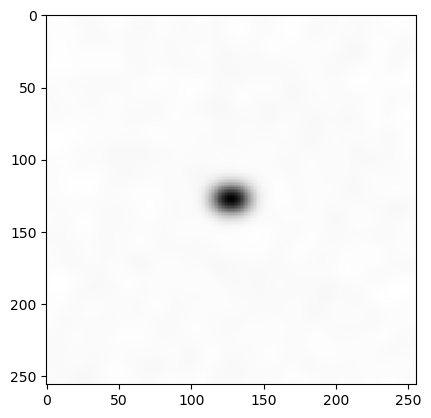

PyObject <matplotlib.image.AxesImage object at 0x12bc31438>

In [25]:
PyPlot.imshow(u,cmap="gray")

# 2.2. Reaction Diffusion

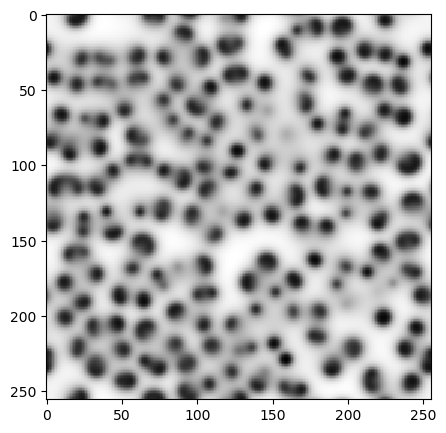

In [33]:
run(`mkdir -p /tmp/hoge`)
fff = glob("*.png","/tmp/hoge");
rm.(fff);

fig = PyPlot.figure("grayscott",figsize=(5,5))
PyPlot.imshow(u,cmap="gray");
PyPlot.savefig(@sprintf("/tmp/hoge/tmp_%06d",0), bbox_inches="tight")


tmax=10000;
tframe=100;

u=u0;
v=v0;
t=0;
for aa in 1:tmax
    u += (difu * laplacian(u,dx) -u.*v.*v + cf*(1.0.-u) ) *dt;
    v += (difv * laplacian(v,dx) +u.*v.*v - (cf+ck)*v ) *dt;
    t += dt;
    if(mod(aa,tframe)==0)
        PyPlot.imshow(u,cmap="gray");
        PyPlot.savefig(@sprintf("/tmp/hoge/tmp_%06d",aa), bbox_inches="tight")
    end
end

In [29]:
# create animation gif from the snapshots
run(`convert -delay 9 -loop 0 /tmp/hoge/tmp_\*.png grayscott.gif`)

Process(`convert -delay 9 -loop 0 '/tmp/hoge/tmp_*.png' grayscott.gif`, ProcessExited(0))

In [30]:
# Define as a function to compare various parameters.

function grayscott(u0, v0, params; t0=0, itermax=10000, ns=101)

    f = params["f"]
    k = params["k"]

    isnap = trunc.(Int, collect(range(0,stop=itermax,length=ns)))

    ts = zeros(ns)
    us = zeros(ns,nx,nx)
    vs = zeros(ns,nx,nx)
    
    ts[1] = t = t0
    us[1,:,:] = u = u0
    vs[1,:,:] = v = v0

    for i in 1:itermax
        du = difu * laplacian(u,dx) -u.*v.*v + f*(1.0.-u)
        dv = difv * laplacian(v,dx) +u.*v.*v - (f+k)*v 

        t += dt
        u += du*dt
        v += dv*dt

        s = findfirst(i .== isnap)
        if(s != nothing)
            ts[s] = t
            us[s,:,:] = u
            vs[s,:,:] = v
        end
    end
    return(Dict("ts" => ts, "us"=>us, "ts"=>ts))
end

grayscott (generic function with 1 method)

In [31]:
fig1 = figure("Gray Scott 1", figsize=(5,5))
ns = size(result1["us"])[1]
snap1 = []
for s in 1:ns
    img = imshow(result1["us"][s,:,:],cmap="gray");
    push!(snap1,[img])
end